In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from scipy.stats import norm

## Load results of MC simulation

In [2]:
with open('results_dict.pkl', 'rb') as pickle_file:
    results_dict = pickle.load(pickle_file)

## Assess convergence rates and asymptotic properties

In [3]:
theta_0 = 1.0   # true ATE
sample_sizes = list(results_dict.keys())
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

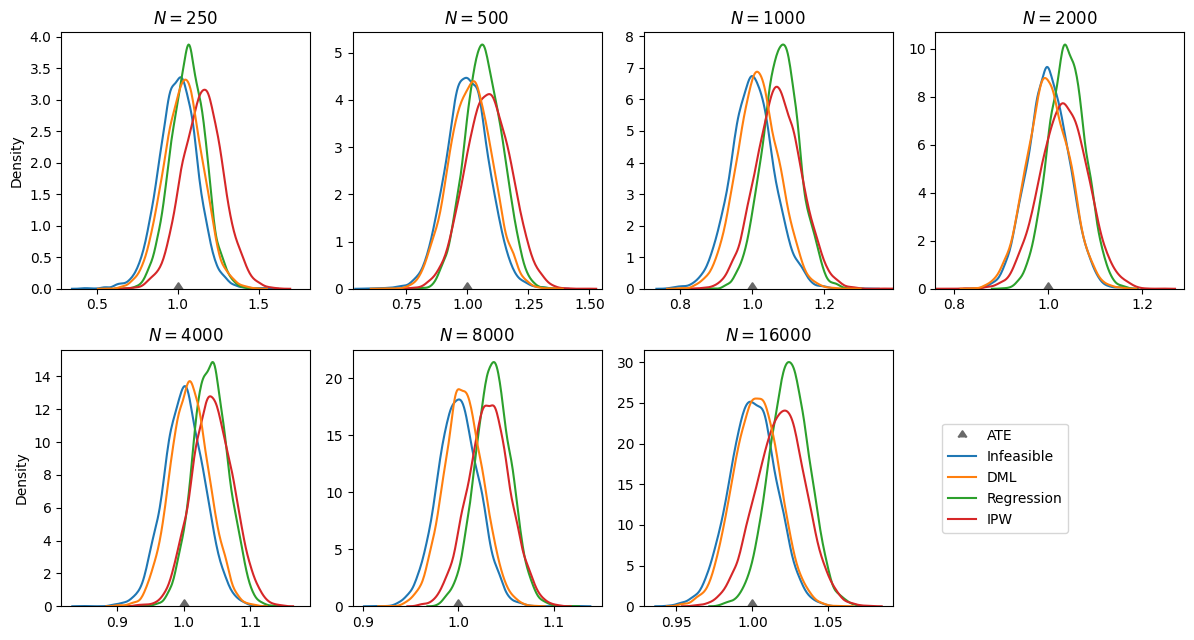

In [4]:
# Visual comparison of estimators
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6.5))

for i, (N, results) in enumerate(results_dict.items()):
    ax = axes.flat[i]
    ax.scatter(theta_0, 0, marker=10, color='dimgrey', label='ATE')
    ate_estimates = results[0]
    sns.kdeplot(ate_estimates[:,0], ax=ax, color=colors[0], label='Infeasible')
    sns.kdeplot(ate_estimates[:,2], ax=ax, color=colors[2], label='Regression')
    sns.kdeplot(ate_estimates[:,3], ax=ax, color=colors[3], label='IPW')
    sns.kdeplot(ate_estimates[:,1], ax=ax, color=colors[1], label='DML')
    ax.set_title(r'$N=$' + f'{N}')
    
    if not (i==0 or i==4):
        ax.set_ylabel('')
    if i==0:
        ax.set_xlim(left=0.28, right=1.82)
    elif i==1:
        ax.set_xlim(left=0.53, right=1.55)
    elif i==2:
        ax.set_xlim(left=0.7, right=1.39)
    elif i==3:
        ax.set_xlim(left=0.76, right=1.29)
    elif i==4:
        ax.set_xlim(left=None, right=1.19)
    elif i==5:
        ax.set_yticks([0, 5, 10, 15, 20])
    if i==6: 
        handles, labels = ax.get_legend_handles_labels()

order = [0, 1, 4, 2, 3]   
axes.flat[-1].legend([handles[j] for j in order], [labels[j] for j in order], 
                     loc='center left', bbox_to_anchor=(0, 0.5))        
axes.flat[-1].axis('off')
fig.tight_layout()

for fmt in ['png', 'pdf']:
    fig.savefig(f'figures/Visual_comparison.{fmt}', dpi=300, bbox_inches='tight')

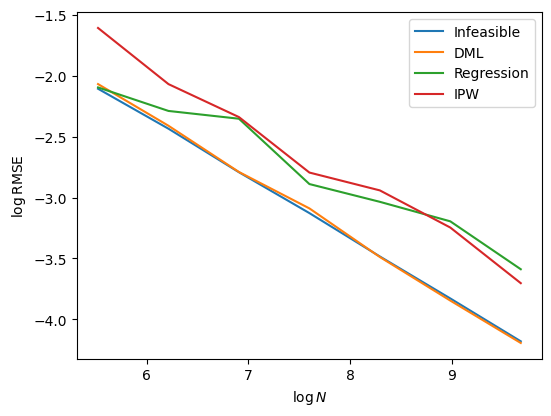

In [5]:
# Convergence rates
rmse = np.empty((len(sample_sizes), 4))

for i, (N, results) in enumerate(results_dict.items()):
    ate_estimates = results[0]
    rmse[i] = np.sqrt(np.mean((ate_estimates-theta_0)**2, axis=0))

plt.figure(figsize=(6, 4.5))
plt.plot(np.log(sample_sizes), np.log(rmse[:,0]), color=colors[0], label='Infeasible')
plt.plot(np.log(sample_sizes), np.log(rmse[:,1]), color=colors[1], label='DML')
plt.plot(np.log(sample_sizes), np.log(rmse[:,2]), color=colors[2], label='Regression')
plt.plot(np.log(sample_sizes), np.log(rmse[:,3]), color=colors[3], label='IPW')
plt.xlabel(r'$\log N$')
plt.ylabel(r'$\log$' + 'RMSE')
plt.legend()

for fmt in ['png', 'pdf']:
    plt.savefig(f'figures/Convergence_rates_1.{fmt}', dpi=300, bbox_inches='tight')

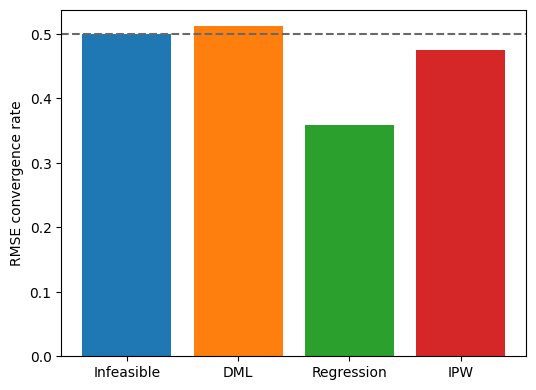

In [6]:
# Convergence rates
slopes = np.polyfit(np.log(sample_sizes), np.log(rmse), 1)[0,:]

plt.figure(figsize=(6, 4.5))
plt.bar(['Infeasible', 'DML', 'Regression', 'IPW'], -slopes, color=colors)
plt.axhline(y=0.5, color='dimgrey', linestyle='--')
plt.ylabel('RMSE convergence rate')

for fmt in ['png', 'pdf']:
    plt.savefig(f'figures/Convergence_rates_2.{fmt}', dpi=300, bbox_inches='tight')

In [7]:
-slopes

array([0.49933213, 0.51200229, 0.35899803, 0.47583166])

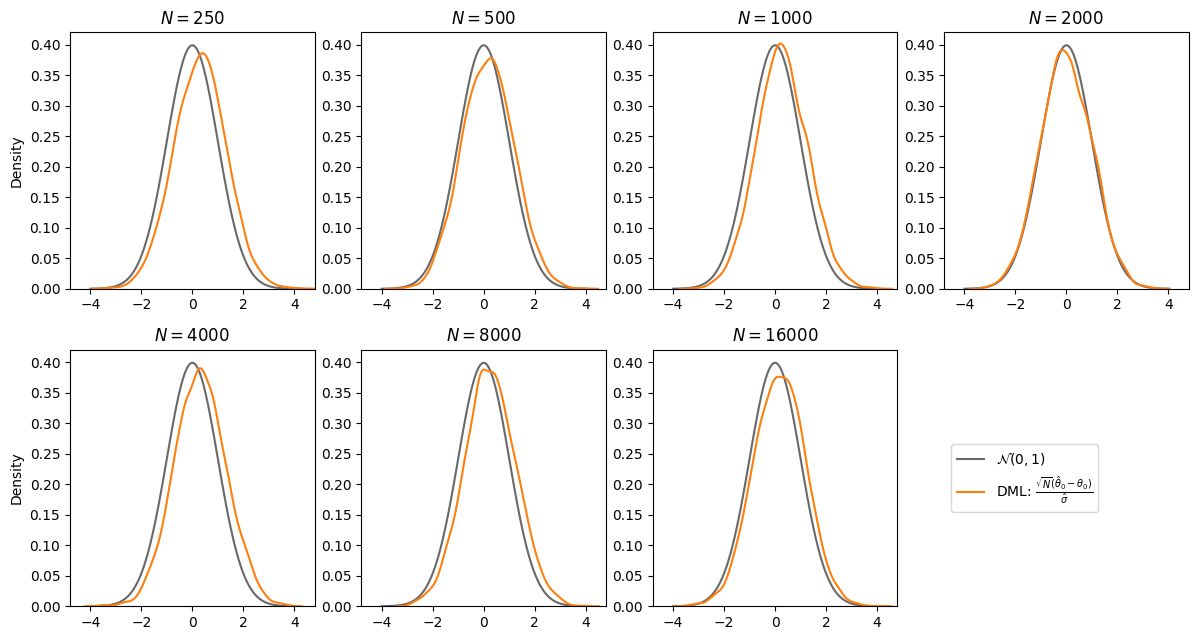

In [8]:
# Asymptotic normality
grid = np.linspace(-4, 4, 100)
pdf_values = norm.pdf(grid)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6.5))

for i, (N, results) in enumerate(results_dict.items()):
    ax = axes.flat[i]
    ate_estimates, sigma_estimates, _ = results
    ax.plot(grid, pdf_values, color='dimgrey', label=r'$\mathcal{N}(0,1)$')
    sns.kdeplot(np.sqrt(N)*(ate_estimates[:,1]-theta_0)/sigma_estimates, ax=ax, color=colors[1],
                label='DML: ' + r'$\frac{\sqrt{N}(\hat{\theta}_0-\theta_0)}{\hat{\sigma}}$')
    ax.set_xlim(left=-4.8, right=4.8)
    ax.set_ylim(bottom=None, top=0.42)
    ax.set_title(r'$N=$' + f'{N}')
    
    if not (i==0 or i==4):
        ax.set_ylabel('')
    if i==0:
        ax.set_xticks([-4, -2, 0, 2, 4])    
    if i==6: 
        handles, labels = ax.get_legend_handles_labels()
  
axes.flat[-1].legend(handles, labels, loc='center left', bbox_to_anchor=(0, 0.5))        
axes.flat[-1].axis('off')
fig.tight_layout()

for fmt in ['png', 'pdf']:
    fig.savefig(f'figures/Asymptotic_normality.{fmt}', dpi=300, bbox_inches='tight')

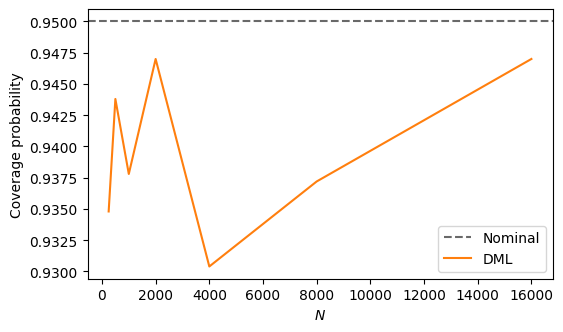

In [9]:
# Coverage probability
cov_prob_list = []

for results in results_dict.values():
    CIs = results[-1]
    cov_prob = np.mean((theta_0>=CIs[:,0]) & (theta_0<=CIs[:,1]))
    cov_prob_list.append(cov_prob)

plt.figure(figsize=(6, 3.5))
plt.axhline(y=0.95, color='dimgrey', linestyle='--', label='Nominal')
plt.plot(sample_sizes, cov_prob_list, color=colors[1], label='DML')

plt.xlabel(r'$N$')
plt.ylabel('Coverage probability')
plt.legend()

for fmt in ['png', 'pdf']:
    plt.savefig(f'figures/Coverage_probability.{fmt}', dpi=300, bbox_inches='tight')